In [36]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

from lib import models, graph, coarsening, utils

In [37]:
ALL_LAWS_PATH = '../data/all-votes/laws_20years.csv'
ALL_ADJACENCY_PATH = '../data/all-votes/all_adjacency.pickle'
VOTES_POSITIONS = '../data/all-votes/all_votes_positions.csv'
ALL_SUBJECT_PATH = '../data/all-votes/bills_20years.csv'
ALL_ADJACENCY_METRIS_PATH = '../data/all-votes/all_adjacency_metric.csv'
pal = {'republican': '#ff0000', 'democrats': '#0000ff'}

In [71]:
all_laws = pd.read_csv(ALL_LAWS_PATH)
all_bills = pd.read_csv(ALL_SUBJECT_PATH)
all_adjacency_metrics = pd.read_csv(ALL_ADJACENCY_METRIS_PATH)
all_laws['law_id'] = all_laws['vote_uri'].apply(lambda x: '_'.join(x.split('/')[4:]).split('.')[0])
all_laws = all_laws.merge(all_bills, on='law_id', how='left')
all_laws = all_adjacency_metrics.merge(all_bills, on='law_id', how='left')

LOOKUP_RESULT = {
    'Agreed to': 'passed', 'Rejected': 'rejected', 'Nomination Confirmed': 'passed',
    'Cloture Motion Agreed to': 'passed', 'Amendment Rejected': 'rejected', 'Confirmed': 'passed',
    'Passed': 'passed', 'Amendment Agreed to': 'passed', 'Motion Rejected': 'rejected',
    'Motion Agreed to': 'passed', 'Bill Passed': 'passed', 'Motion to Table Agreed to': 'passed',
    'Cloture Motion Rejected': 'rejected', 'Motion to Proceed Agreed to': 'passed',
    'Cloture on the Motion to Proceed Agreed to': 'passed', 'Cloture on the Motion to Proceed Rejected': 'rejected'
}
all_laws['result_ok'] = all_laws.result.apply(lambda x: LOOKUP_RESULT.get(x, 'undefinied'))

votes_positions = pd.read_csv(VOTES_POSITIONS)
    
print(all_laws.shape)
print(votes_positions.shape)

(6834, 33)
(683034, 7)


In [75]:
all_laws = all_laws[all_laws['result_ok'].apply(lambda x: x in ['passed', 'rejected'])]

In [129]:
def numeric_votes(x):
    if x == 'Yes':
        return 1
    elif x == 'Not Voting' or pd.isnull(x):
        return 0.5 # we can put np.nan and then fill with the median or mean, whatever for now
    else:
        return 0

datas = {}

for c in list(all_laws.congress.unique()):
    filtered = all_laws[all_laws.congress == c]
    laws_ids = list(filtered['vote_uri'])
    filtered_votes = votes_positions[votes_positions.vote_uri.apply(lambda x: x in laws_ids)]
    members = pd.DataFrame(list(filtered_votes['member_id'].unique())).rename(columns={0: 'member_id'})
    n = len(laws_ids)
    d = len(members)
    y = filtered.result_ok.apply(lambda x: 0 if x=='rejected' else 1).values
    X = np.zeros((n, d))
    
    for i, l in enumerate(laws_ids):
        votes = (filtered_votes[filtered_votes.vote_uri == l]
                 .merge(members, how='right')
                 .sort_values(['party', 'member_id']))
        feature = votes.vote_position.apply(numeric_votes).values
        X[i] = feature
        
    # it will select by time and it is on purpose because our main is predict the future based on the past
    n_train = n // 2
    n_val = n // 5

    X_train = X[:n_train]
    X_val   = X[n_train:n_train+n_val]
    X_test  = X[n_train+n_val:]

    y_train = y[:n_train]
    y_val   = y[n_train:n_train+n_val]
    y_test  = y[n_train+n_val:]

    datas[c] = {'X_train': X_train, 'y_train': y_train,
                'X_val': X_val, 'y_val': y_val,
                'X_test': X_test, 'y_test': y_test}
    

In [133]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 40
params['batch_size']     = 10 # changed
params['eval_frequency'] = 100 # changed

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = y.max() + 1
assert C == np.unique(y).size

# Architecture.
params['F']              = [32, 64]  # Number of graph convolutional filters.
params['K']              = [20, 20]  # Polynomial orders.
params['p']              = [4, 2]    # Pooling sizes.
params['M']              = [512, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 0.5 # changed
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = n_train / params['batch_size']

def fit(X_train, X_val, X_test, y_train, y_val, y_test):     
    min_acc = y_train.sum() / y_train.shape[0]
    
    dist, idx = graph.distance_scipy_spatial(X_train.T, k=10, metric='euclidean')
    A = graph.adjacency(dist, idx).astype(np.float32)
    graphs, perm = coarsening.coarsen(A, levels=3, self_connections=False)
    X_train = coarsening.perm_data(X_train, perm)
    X_val = coarsening.perm_data(X_val, perm)
    X_test = coarsening.perm_data(X_test, perm)
    L = [graph.laplacian(A, normalized=True) for A in graphs]
#     graph.plot_spectrum(L)
    
    model = models.cgcnn(L, **params)
    accuracy, loss, t_step = model.fit(X_train, y_train, X_val, y_val)
    res = model.evaluate(X_test, y_test)
    return {'min_acc': min_acc, 'graph': graph, 'acc': res, 'A': A}

## Models by Congress

Layer 0: M_0 = |V| = 112 nodes (12 added),|E| = 749 edges
Layer 1: M_1 = |V| = 56 nodes (4 added),|E| = 365 edges
Layer 2: M_2 = |V| = 28 nodes (1 added),|E| = 130 edges
Layer 3: M_3 = |V| = 14 nodes (0 added),|E| = 38 edges
NN architecture
  input: M_0 = 112
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 112 * 32 / 4 = 896
    weights: F_0 * F_1 * K_1 = 1 * 32 * 20 = 640
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 28 * 64 / 2 = 896
    weights: F_1 * F_2 * K_2 = 32 * 64 * 20 = 40960
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 896 * 512 = 458752
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 2
    weights: M_3 * M_4 = 512 * 2 = 1024
    biases: M_4 = 2
step 100 / 1216 (epoch 3.29 / 40):
  learning_rate = 8.57e-04, loss_average = 1.14e+00
  validation accuracy: 91.74 (111 / 121), f1 (weighted): 91.27, loss: 1.16e+00
  time: 4s (wall 2s)
step 200 / 1216 (epoch 6.58 / 40

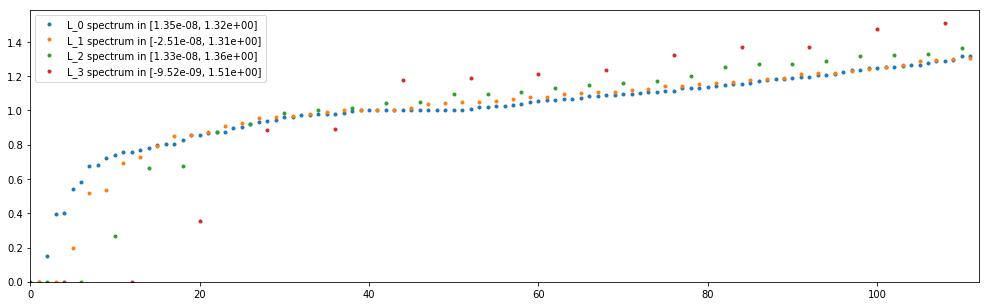

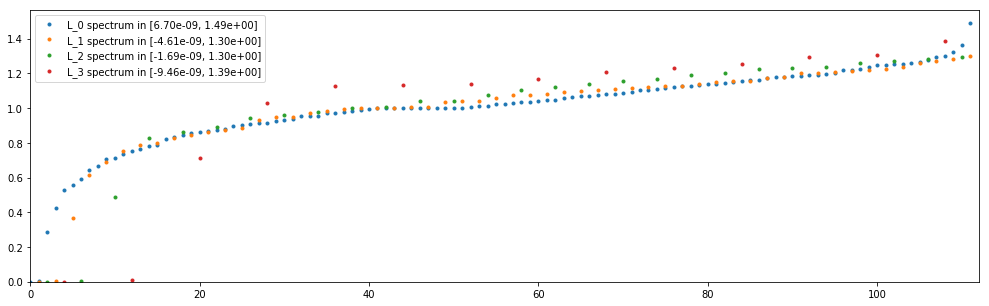

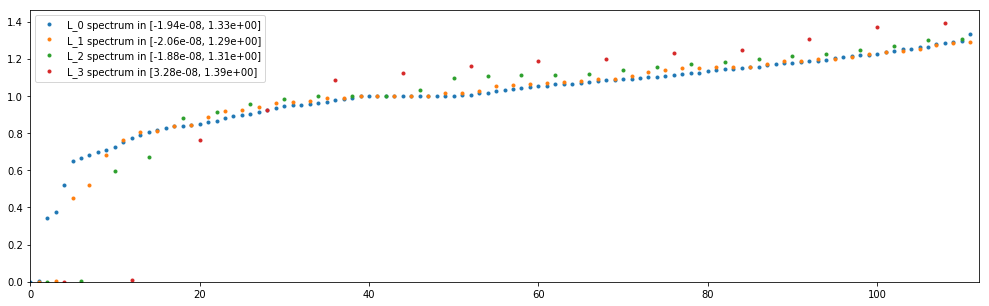

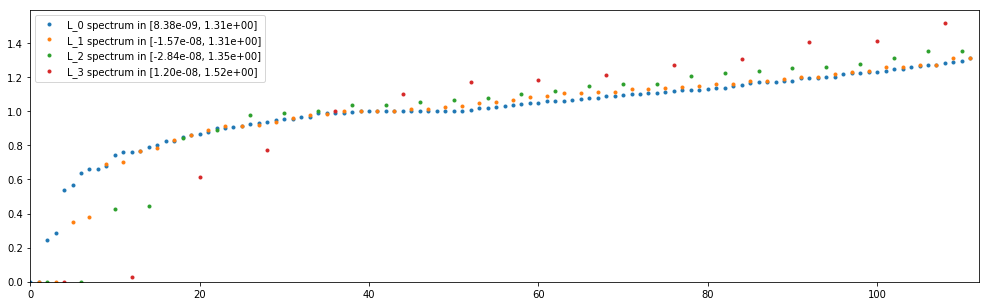

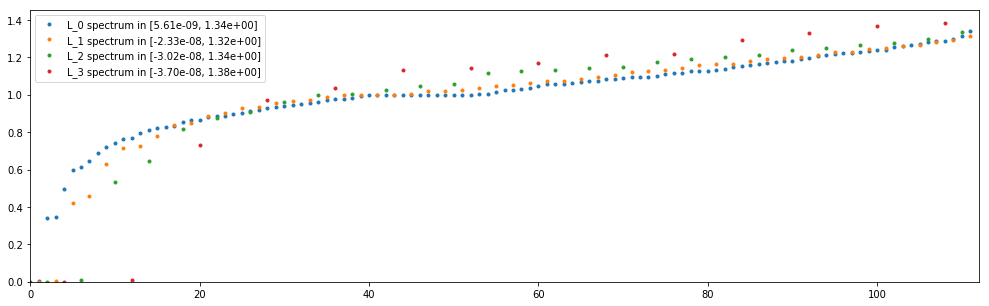

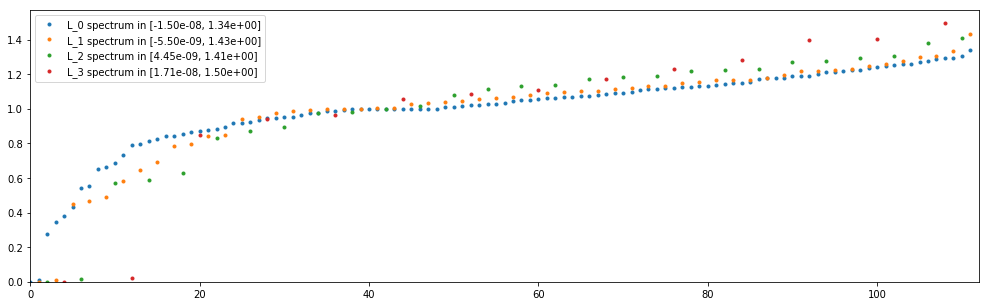

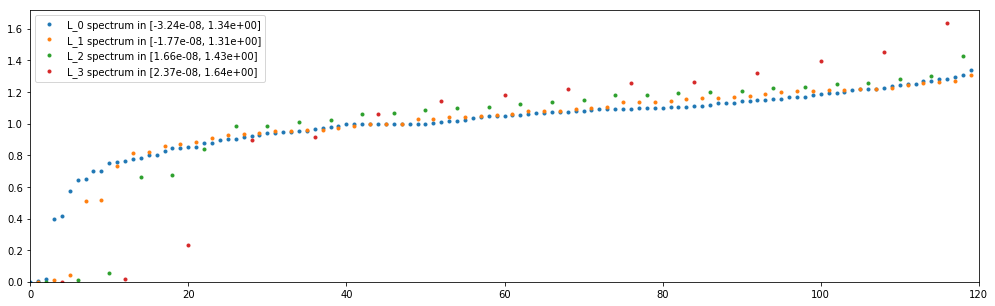

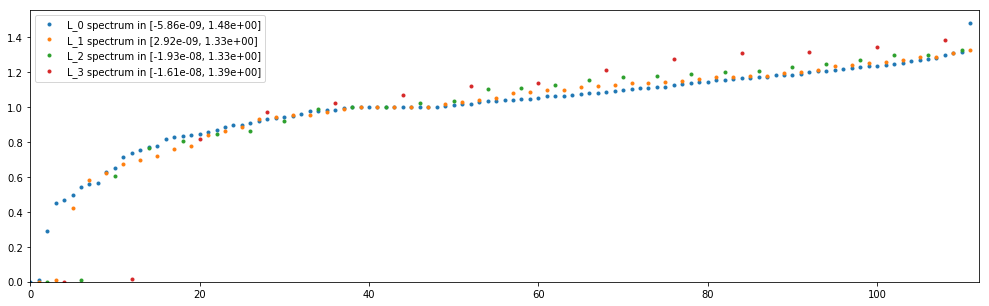

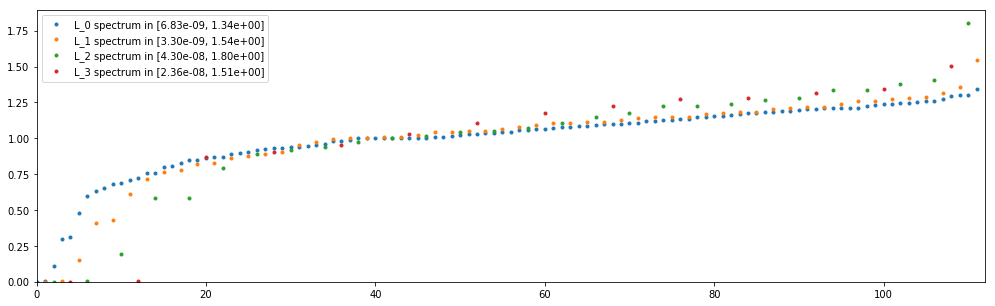

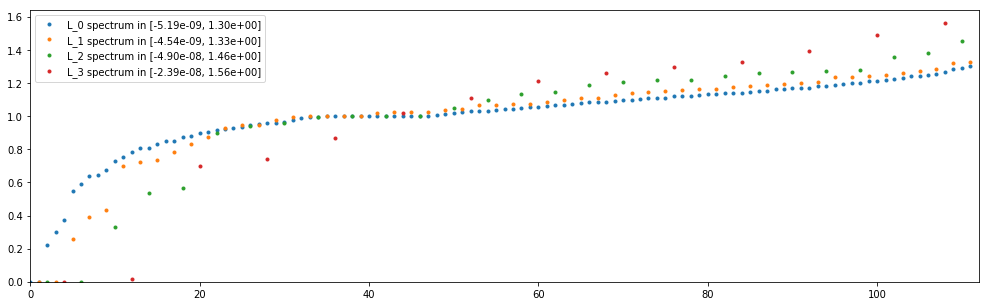

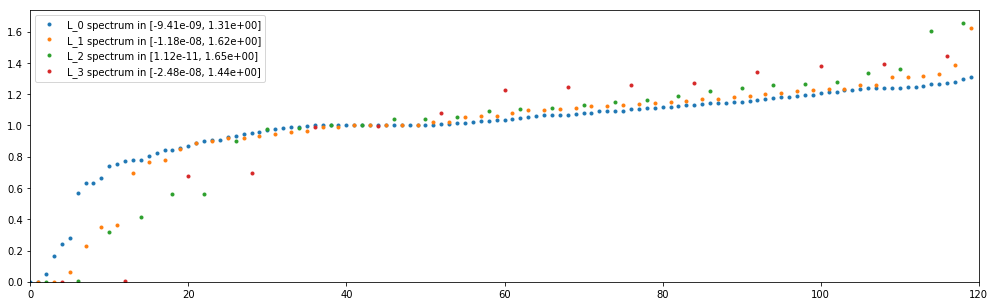

In [136]:
results = dict([(k, fit(**d)) for k, d in datas.items()])

In [142]:
f, ax = plt.subplots(4, 3, figsize=(20, 20))
positions = np.array(range(12)).reshape(4, 3)

for i, r in enumerate(results):
    pos = np.where(positions==r)
    A = results[r]['A']
    
    plt.spy(A, markersize=2, color='black');
    plt.title(r)

NameError: name 'A' is not defined

## Model with all congresses
There are 231 unique members over the 20 years, it means that one senator participates in many congresses. Let's try to build a model with all senator at once

In [154]:
laws_ids = list(all_laws['vote_uri'])
filtered_votes = votes_positions[votes_positions.vote_uri.apply(lambda x: x in laws_ids)]
members = pd.DataFrame(list(filtered_votes['member_id'].unique())).rename(columns={0: 'member_id'})
n = len(laws_ids)
d = len(members)
y = all_laws.result_ok.apply(lambda x: 0 if x=='rejected' else 1).values
X = np.zeros((n, d))
    
for i, l in enumerate(laws_ids):
    votes = (filtered_votes[filtered_votes.vote_uri == l].merge(members, how='right')
                 .sort_values(['party', 'member_id']))
    feature = votes.vote_position.apply(numeric_votes).values
    X[i] = feature
        
    # it will select by time and it is on purpose because our main is predict the future based on the past
    n_train = n // 2
    n_val = n // 5

    X_train = X[:n_train]
    X_val   = X[n_train:n_train+n_val]
    X_test  = X[n_train+n_val:]

    y_train = y[:n_train]
    y_val   = y[n_train:n_train+n_val]
    y_test  = y[n_train+n_val:]

In [ ]:
all_result = fit(X_train, X_val, X_test, y_train, y_val, y_test)

Layer 0: M_0 = |V| = 896 nodes (665 added),|E| = 2090 edges
Layer 1: M_1 = |V| = 448 nodes (277 added),|E| = 1567 edges
Layer 2: M_2 = |V| = 224 nodes (89 added),|E| = 1186 edges
Layer 3: M_3 = |V| = 112 nodes (0 added),|E| = 974 edges
NN architecture
  input: M_0 = 896
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 896 * 32 / 4 = 7168
    weights: F_0 * F_1 * K_1 = 1 * 32 * 20 = 640
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 224 * 64 / 2 = 7168
    weights: F_1 * F_2 * K_2 = 32 * 64 * 20 = 40960
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 7168 * 512 = 3670016
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 2
    weights: M_3 * M_4 = 512 * 2 = 1024
    biases: M_4 = 2
step 100 / 13212 (epoch 0.30 / 40):
  learning_rate = 8.57e-04, loss_average = 7.44e+00
  validation accuracy: 82.29 (1087 / 1321), f1 (weighted): 81.65, loss: 7.49e+00
  time: 51s (wall 19s)
step 200 / 